### Setup

In [1]:
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import pathlib
from pathlib import Path
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.constraints import maxnorm
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import cifar10
import utilities as util


### Load the cloud dataset
Initially shuffle and reshuffle_each_iteration were both set to False. This was not a good choice because when unshuffled, the training data is chosen from the top of the list of files and the validation data is chosen from the bottom. This results in the training data being too different from the validation data to be able to classify the validation data. After setting these parameters to true, validation accuracy went from ~.3 to ~.85.

In [16]:
data_dir = pathlib.Path('/home/rey/ML/data/test')

image_count = len(list(data_dir.glob('*/*.jpg')))
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)


### Summary of training/validation data

there are 2543 images

with 11 different classes
 ['Ac' 'As' 'Cb' 'Cc' 'Ci' 'Cs' 'Ct' 'Cu' 'Ns' 'Sc' 'St'] 



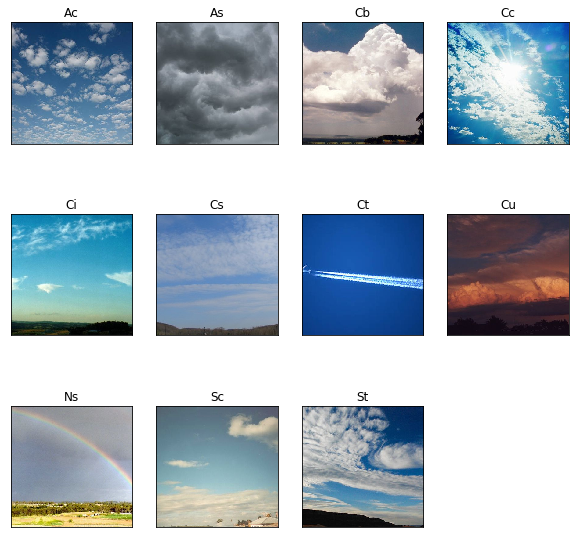

In [17]:
print('there are', image_count, 'images\n')
class_names = util.get_class_names(data_dir)
num_classes = len(class_names)
print('with', num_classes, 'different classes\n', class_names, '\n')
util.plot_ex_images(data_dir)

In [18]:
val_size = int(image_count * 0.2)

train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print('20 % of the input data is allocated to the validation set so that:')
print(tf.data.experimental.cardinality(train_ds).numpy(), 'images are used for training')
print(tf.data.experimental.cardinality(val_ds).numpy(), 'images are used for validation')

20 percent of the data is allocated to the validation set so that:
2035 images are used for training
508 images are used for validation


## optimize algorithm
tf.data builds a performance model of the input pipeline and runs an optimization algorithm to find a good allocation of its CPU budget across all tunable operations. While the input pipeline is running, tf.data tracks the time spent in each operation, so that these times can be fed into the optimization algorithm.



In [11]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(util.process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(util.process_path, num_parallel_calls=AUTOTUNE)

train_ds = util.configure_for_performance(train_ds, AUTOTUNE)
val_ds = util.configure_for_performance(val_ds, AUTOTUNE)

image_batch, label_batch = next(iter(train_ds))


In [12]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]


In [6]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

